<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy import stats

import copy

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [3]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy


In [4]:
import importlib

# Import your modules initially
import library.pipeline

# Reload the modules in case they were updated
importlib.reload(library.pipeline)

# Now you can import specific classes/functions
from library.pipeline.pipeline import Pipeline
from library.pipeline.pipeline_manager import PipelineManager

## Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT). Notebook-level constants should be written in the cell assigned to it (see below)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write a content index with the content included in that section (see 'feature engineering' section as an example)
- Please write paragraphs before and after each cell explain what u are about to do and the conclusions, correspondingly. Do not assume they are too obvious.
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)
- Ideally, add a "Questions" and "Things to be done" section in each major sections where u write about futher iterations u want to do (while sharing in with the rest)


## Set-up

In [5]:
dataset_path ="./dataset/dynamic_dataset.csv"
results_path = "results/results.csv"

We start off with a pipeline for all the models. Then at some moment, whenever we think the pipelines will diverge, we remove the by-object-refrence (that we will create in the next cell), and create a new copy with our modifications ready.

In [6]:
default_pipeline = ensembled_pipeline = tree_pipeline = linear_pipeline = baseline_pipeline = example = Pipeline(
                        dataset_path=dataset_path, 
                        results_path=results_path,
                        model_type="classification")

In [7]:
pipelines = {
            "models": {
                  "ensembled": ensembled_pipeline,
                  "tree-based": tree_pipeline,
                  "linear": linear_pipeline,
                  }, 
            "baseline": {
                  "logistic": baseline_pipeline, 
                  "example":  example               
            }
}
pipeline_manager = PipelineManager(pipelines)

Here I show an example of how we will be working with by-object-reference.

In [8]:
baseline_pipeline.dataset.example_attribute = "1"

In [9]:
default_pipeline.dataset.example_attribute

'1'

However, if we do a (deep) copy:
Note that the difference between a deep and a shallow copy is that the former copies all the objects that are inside the class. We need that.
We will overwrite the prior attribute and show is this is not propagated to the other results anymore

In [10]:
new_pipeline = copy.deepcopy(default_pipeline)
new_pipeline.dataset.example_attribute = "2"

In [11]:
default_pipeline.dataset.example_attribute

'1'

It may also be of interest for you to propagate the same method's invokation to all the pipelines within the pipeline manager. For instance, after a divergence in, lets say, feature scaling, you may need to fit all the models in the corresponding pipelines. You would want to avoid reduntandly calling the same method with the same parameters for all the Pipeline class instances. In order to do so, we present an example that avoids such annoyance

In [12]:
pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="example", print_results=True)

Pipeline example in category baseline has diverged
 Pipeline schema is now: {'models': {'ensembled': <library.pipeline.pipeline.Pipeline object at 0x155f27d10>, 'tree-based': <library.pipeline.pipeline.Pipeline object at 0x155f27d10>, 'linear': <library.pipeline.pipeline.Pipeline object at 0x155f27d10>}, 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline object at 0x155f27d10>, 'example': <library.pipeline.pipeline.Pipeline object at 0x1055f6c90>}}


In [13]:
pipeline_manager.pipelines["baseline"]["example"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd")

Whats goooddd from 5741205456. You are at automatic feature selection!


In [14]:
pipeline_manager.all_pipelines_execute(methodName="speak", message="Hello, world!")

Hello, world! from 5736922384
Hello, world! from 4385107088


{'models': {'ensembled': None}, 'baseline': {'example': None}}

A method present deeper down the class:

Instead of doing:
'pipeline_manager.pipelines["baseline"]["logistic"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd") for all objects'

we can do:

In [15]:
pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_selection.automatic_feature_selection.speak", message="Whats good")

Whats good from 5715228240. You are at automatic feature selection!
Whats good from 5741205456. You are at automatic feature selection!


{'models': {'ensembled': None}, 'baseline': {'example': None}}

In [16]:
# lets delete the example obj
del new_pipeline 
del pipeline_manager.pipelines["baseline"]["example"]

In [17]:
pipeline_manager.pipelines

{'models': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x155f27d10>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x155f27d10>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x155f27d10>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x155f27d10>}}

<hr>

# Start Of The Pipeline

In [18]:
default_pipeline.dataset.df.head()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Hash,Category,Family,reboot
0,31053,2448,14044,23472,74824,2452,0,8919,4786,4132,...,1635,2351,3285,1551,11221,193,f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...,Trojan_SMS,opfake,before
1,107787,21976,11852,74548,69052,23152,0,25341,20965,4375,...,1816,826,1544,2045,8457,189,556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...,Trojan_SMS,opfake,before
2,86584,18460,12284,59992,91548,19376,0,24500,21378,3121,...,2244,3406,1565,2819,10780,195,398322f94b5bfa2a9e7b3756a4cf409764595003280c48...,Trojan_SMS,fakeinst,before
3,41248,924,10328,36280,55768,928,0,10082,7281,2800,...,974,4134,3138,1556,11739,191,4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...,Trojan_SMS,fakeinst,before
4,38621,5080,12392,27388,71048,5088,0,9077,5750,3326,...,936,2298,3752,1992,10488,188,6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...,Trojan_SMS,fakeinst,before


In [19]:
default_pipeline.dataset.df.rename(columns={"reboot": "Reboot"}, inplace=True) # consistency with other features' names
default_pipeline.dataset.df.drop(columns=["Family", "Hash"], inplace=True) # We have decided to use only category as target variable; Hash is temporary while im debugging (it will be deleted in EDA)

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them.
Please access this document for a complete problem context description: https://docs.google.com/document/d/1yH9gvnJVSH9GLv9ATQ5JQWA2z8Jy4umxxRfMF-y2fiU/edit?usp=sharing

# 1. EDA

This section below shall be deleted

In [20]:
default_pipeline.preprocessing.remove_duplicates()

No duplicates found in the dataset


In [21]:
default_pipeline.preprocessing.get_missing_values()

No missing values found in the dataset


In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

## Data Type Distribution

In [22]:
# # Get the data types of each column
# data_types = dataset.df.dtypes

# # Count the frequency of each data type
# type_counts = data_types.value_counts()

# # Plotting the frequency of data types
# type_counts.plot(kind='bar', color='skyblue')

# # Add title and labels
# plt.title('Frequency of Data Types in DataFrame')
# plt.xlabel('Data Type')
# plt.ylabel('Frequency')

We can see that most columns are numerical. Lets gets to see which are the variables that are of type object.

In [23]:
# df_onlyCols = dataset.df.select_dtypes(include=["object"]).columns
# df_onlyCols

## Summary Statistics Overview

## Histograms


In [24]:
"""# Select only numerical features
numerical_cols = dataset.df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot histograms
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()"""

'# Select only numerical features\nnumerical_cols = dataset.df.select_dtypes(include=[np.number]).columns\n\n# Define number of rows and columns for subplots\nnum_features = len(numerical_cols)\ncols = 4  # Number of columns per row\nrows = math.ceil(num_features / cols)  # Calculate required rows\n\n# Create subplots\nfig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))\naxes = axes.flatten()  # Flatten to easily iterate\n\n# Plot histograms\nfor i, col in enumerate(numerical_cols):\n    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve\n    axes[i].set_title(col)\n\n# Remove empty subplots\nfor i in range(num_features, len(axes)):\n    fig.delaxes(axes[i])\n\nplt.tight_layout()\nplt.show()'

We can see most distributions tend to be right-skewed and only a small portion follows a normal distribution. This right-skewness will be dealt in feature-engineering.

In [25]:
"""# Select only numerical features
numerical_cols = dataset.df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot boxplots
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=dataset.df[col], ax=axes[i])  # Boxplot for each feature
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()"""

'# Select only numerical features\nnumerical_cols = dataset.df.select_dtypes(include=[np.number]).columns\n\n# Define number of rows and columns for subplots\nnum_features = len(numerical_cols)\ncols = 4  # Number of columns per row\nrows = math.ceil(num_features / cols)  # Calculate required rows\n\n# Create subplots\nfig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))\naxes = axes.flatten()  # Flatten to easily iterate\n\n# Plot boxplots\nfor i, col in enumerate(numerical_cols):\n    sns.boxplot(x=dataset.df[col], ax=axes[i])  # Boxplot for each feature\n    axes[i].set_title(col)\n\n# Remove empty subplots\nfor i in range(num_features, len(axes)):\n    fig.delaxes(axes[i])\n\nplt.tight_layout()\nplt.show()'

## Numerical Features

Seemed to be grouped by prefixes: Memory, Network, Battery, Logcat, Process y API.

According to dataset authors to capture how various malware families and categories behave at runtime, the analysis relies on six distinct sets of features obtained after executing each sample within a controlled emulated environment. These feature groups offer a comprehensive view of the malware's dynamic activity.

This categories appear before the first _ in every feature label and are defined as:


"Memory: Memory features define activities performed by malware by utilizing memory.

API: Application Programming Interface (API) features delineate the communication between two applications.

Network: Network features describe the data transmitted and received between other devices in the network. It indicates foreground and background network usage.

Battery: Battery features describe the access to battery wakelock and services by malware.

Logcat: Logcat features write log messages corresponding to a function performed by malware.

Process: Process features count the interaction of malware with total number of processes."



In [26]:
"""numeric_cols = dataset.df.select_dtypes(include='number').columns

# Grouping based on the first prefix before "_"
prefix_groups = defaultdict(list)

for col in numeric_cols:
    prefix = col.split("_")[0]  # Get the first word before the underscore
    prefix_groups[prefix].append(col)

for prefix, columns in prefix_groups.items():
    print(f"\n {prefix} ({len(columns)} features):")
    for col in columns:
        print(f"  - {col}")"""

'numeric_cols = dataset.df.select_dtypes(include=\'number\').columns\n\n# Grouping based on the first prefix before "_"\nprefix_groups = defaultdict(list)\n\nfor col in numeric_cols:\n    prefix = col.split("_")[0]  # Get the first word before the underscore\n    prefix_groups[prefix].append(col)\n\nfor prefix, columns in prefix_groups.items():\n    print(f"\n {prefix} ({len(columns)} features):")\n    for col in columns:\n        print(f"  - {col}")'

## Categorical Features

In [27]:
"""#Statistical summary for categorical features
dataset.df.describe(include=["object", "category", "bool"])"""

'#Statistical summary for categorical features\ndataset.df.describe(include=["object", "category", "bool"])'

In [28]:
"""print(dataset.df[['Hash', 'Category', 'Family']].head())"""

"print(dataset.df[['Hash', 'Category', 'Family']].head())"

Hash: unique identifier that represents each malware sample. <<<>>>THIS IS PROBABLY WRONG<<<>>>

Category: general classification of the malware sample based on its behavior.

Family: more fine-grained grouping of malware based on its codebase or origin

For hash, it will first be checked if the same malware before and after reboot contains the same hash value.

In [29]:
"""# Count how many times each hash appears in 'before' and 'after'
hash_reboot_counts =dataset.df.groupby(['Hash', 'reboot']).size().unstack(fill_value=0)

# Hashes in both with exactly one in each
hashes_with_one_each = hash_reboot_counts[
    (hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1)
].index

# Hashes in both but with extra rows
hashes_in_both_but_not_clean = hash_reboot_counts[
    (hash_reboot_counts['before'] > 0) &
    (hash_reboot_counts['after'] > 0) &
    ~((hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1))
].index

# Total unique hashes
total_unique_hashes = dataset.df['Hash'].nunique()

# Hashes in only one reboot condition
hashes_in_one_condition = hash_reboot_counts[
    (hash_reboot_counts['before'] == 0) | (hash_reboot_counts['after'] == 0)
]

# Only once in one reboot condition
only_once_in_one = hashes_in_one_condition[
    (hashes_in_one_condition['before'] == 1) | (hashes_in_one_condition['after'] == 1)
]

# More than once in one reboot condition
more_than_once_in_one = hashes_in_one_condition[
    ((hashes_in_one_condition['before'] > 1) & (hashes_in_one_condition['after'] == 0)) |
    ((hashes_in_one_condition['after'] > 1) & (hashes_in_one_condition['before'] == 0))
]

# Split those into counts
more_than_once_in_before = more_than_once_in_one[more_than_once_in_one['before'] > 1]
more_than_once_in_after = more_than_once_in_one[more_than_once_in_one['after'] > 1]

# --- PRINT RESULTS ---
print(f"Hashes with EXACTLY one row in BOTH before and after: {len(hashes_with_one_each)}")
print(f"Hashes in BOTH, BUT with extra rows: {len(hashes_in_both_but_not_clean)}")

print(f"\nHashes in ONLY ONE reboot condition:")
print(f"• Appearing ONLY ONCE: {len(only_once_in_one)}")
print(f"• Appearing MORE THAN ONCE: {len(more_than_once_in_one)}")
print(f"   - More than once in BEFORE: {len(more_than_once_in_before)}")
print(f"   - More than once in AFTER: {len(more_than_once_in_after)}")

print(f"\nTotal breakdown:")
print(f"• In BOTH (any): {len(hashes_with_one_each) + len(hashes_in_both_but_not_clean)}")
print(f"• In ONLY ONE reboot: {len(hashes_in_one_condition)}")
print(f"• TOTAL unique hashes: {total_unique_hashes}")
"""

'# Count how many times each hash appears in \'before\' and \'after\'\nhash_reboot_counts =dataset.df.groupby([\'Hash\', \'reboot\']).size().unstack(fill_value=0)\n\n# Hashes in both with exactly one in each\nhashes_with_one_each = hash_reboot_counts[\n    (hash_reboot_counts[\'before\'] == 1) & (hash_reboot_counts[\'after\'] == 1)\n].index\n\n# Hashes in both but with extra rows\nhashes_in_both_but_not_clean = hash_reboot_counts[\n    (hash_reboot_counts[\'before\'] > 0) &\n    (hash_reboot_counts[\'after\'] > 0) &\n    ~((hash_reboot_counts[\'before\'] == 1) & (hash_reboot_counts[\'after\'] == 1))\n].index\n\n# Total unique hashes\ntotal_unique_hashes = dataset.df[\'Hash\'].nunique()\n\n# Hashes in only one reboot condition\nhashes_in_one_condition = hash_reboot_counts[\n    (hash_reboot_counts[\'before\'] == 0) | (hash_reboot_counts[\'after\'] == 0)\n]\n\n# Only once in one reboot condition\nonly_once_in_one = hashes_in_one_condition[\n    (hashes_in_one_condition[\'before\'] == 1) 

A total of 19,169 hashes appear exactly once in both before and after conditions. These are highly reliable for paired  comparisons, ideal for understanding how reboot affects malware behavior.


There are 158 hashes that appear in both reboot states but not exactly once in each. These extra instances may come from inconsistencies in data capture like multiple logs for the same sample and should be checked.

A significant portion of samples appear only in one reboot condition. This is consistent with limitations described in the original dataset paper, where some malware samples failed to execute after the reboot. However, what is curious is that some still have been logged more than once.


In [30]:
"""dataset.df.drop(columns=['Hash'], inplace=True)
'''
The Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.
It serves as an identifier for each malware sample. Including this column in modeling
would not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are
sensitive to high-cardinality categorical features.
 <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the 
  argumentation in a text cell not in this type of comments. <<<>>>
'''"""

"dataset.df.drop(columns=['Hash'], inplace=True)\n'''\nThe Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.\nIt serves as an identifier for each malware sample. Including this column in modeling\nwould not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are\nsensitive to high-cardinality categorical features.\n <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the \n  argumentation in a text cell not in this type of comments. <<<>>>\n'''"

This research will be using both Category and Family as the target variables for classification.

## Reboot Analysis

In [31]:
"""print(dataset.df["reboot"].value_counts())"""

'print(dataset.df["reboot"].value_counts())'

The imbalance observed in the dataset, with 28,380 samples collected before reboot and only 25,059 after reboot, is explained by limitations found during the dynamic analysis. The authors of the dataset note that "there was no entry point in some Android malware samples and some Android malware samples stopped abruptly." This means that certain malware applications either failed to launch or terminated unexpectedly during execution, preventing the collection of dynamic behavior data, particularly after the reboot phase.

Additionally, the study highlights another critical limitation: "the dynamic analysis is performed in an emulator. Some malware samples are able to detect the emulated environment and are not executed." This behavior reflects common anti-analysis techniques used by sophisticated malware, which can detect when they are running in a sandbox or emulator and intentionally suspend their malicious actions.




<<<>>>THIS ANALYSIS IS SUPER GOOD (you can delete this comment)<<<>>>

The displayed features are the top 10  most affected by reboot showing a clear reboot-sensitive behavior.

In [32]:
"""#Category distribution across reboot
plt.figure(figsize=(12, 6))
sns.countplot(data=dataset.df, x='Category', hue='reboot')
plt.title("Malware Categories by Reboot Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""


'#Category distribution across reboot\nplt.figure(figsize=(12, 6))\nsns.countplot(data=dataset.df, x=\'Category\', hue=\'reboot\')\nplt.title("Malware Categories by Reboot Condition")\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()'

To identify which numeric features are most influenced by the reboot condition, the dataset will be grouped by the reboot variable, separating entries collected before and after the device reboot. Within each group, the mean of every numeric feature will be computed, allowing for the comparison of average behavior across both states.

A new column labeled 'diff' was then added, representing the difference between the mean values after and before the reboot for each feature. A positive value indicates that the feature increased after reboot, while a negative value shows it decreased.

In [33]:
"""reboot_means = dataset.df.groupby('reboot').mean(numeric_only=True).T
reboot_means['diff'] = reboot_means['after'] - reboot_means['before']
reboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)

reboot_means_sorted.head(10)"""

"reboot_means = dataset.df.groupby('reboot').mean(numeric_only=True).T\nreboot_means['diff'] = reboot_means['after'] - reboot_means['before']\nreboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)\n\nreboot_means_sorted.head(10)"

The results reveal that several features show clear shifts after reboot. Specially, network-related features such as Network_TotalReceivedBytes and Network_TotalTransmittedBytes demonstrate significant increases, suggesting that some malware types intensify data transmission once the device has rebooted. Memory features like Memory_SharedClean, Memory_HeapSize, and Memory_HeapAlloc also show increased values after reboot, indicating greater memory use or altered memory management after reboot.
This shows that the reboot condition plays an important role in runtime behavior and should be treated as an important factor in exploratory analysis and modeling.

## Family

In [34]:
"""#How many categories each family belongs to
dataset.df.groupby("Family")["Category"].nunique().sort_values(ascending=False)"""

'#How many categories each family belongs to\ndataset.df.groupby("Family")["Category"].nunique().sort_values(ascending=False)'

Almost every family is either unknown or unique


In [35]:
# <<<Error: NameError: name 'family_to_category' is not defined>>> (this Irina's code; copied from Argentinan guy's notebook)
# multi_cat_families = family_to_category[family_to_category > 1]
# print(f"Number of families mapping to multiple categories: {len(multi_cat_families)}")
# print(multi_cat_families)

There is only one Family that maps to multiple categories, and is the placeholder unknown.

The following code displays how many samples with unknown family labels belong to each malware category.

In [36]:
"""dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()"""

'dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()'

In [37]:
"""# Step 1: Count unique families per category
family_amount = dataset.df.groupby("Category")["Family"].nunique()

# Step 2: Total number of instances per category
total_per_category = dataset.df["Category"].value_counts()

# Step 3: Count how many of those are <unknown> per category
unknown_amount = dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()

# Step 4: Combine all stats into a summary table
summary_df = pd.DataFrame({
    "Family_amount": family_amount,
    "Total_category": total_per_category,
    "Unknown_amount": unknown_amount
}).fillna(0).astype({"Unknown_amount": int})

# Step 5: Calculate percentage of unknowns per category
summary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)

# Reorder columns for readability
summary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]

# Display the summary
print(summary_df)"""

'# Step 1: Count unique families per category\nfamily_amount = dataset.df.groupby("Category")["Family"].nunique()\n\n# Step 2: Total number of instances per category\ntotal_per_category = dataset.df["Category"].value_counts()\n\n# Step 3: Count how many of those are <unknown> per category\nunknown_amount = dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()\n\n# Step 4: Combine all stats into a summary table\nsummary_df = pd.DataFrame({\n    "Family_amount": family_amount,\n    "Total_category": total_per_category,\n    "Unknown_amount": unknown_amount\n}).fillna(0).astype({"Unknown_amount": int})\n\n# Step 5: Calculate percentage of unknowns per category\nsummary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)\n\n# Reorder columns for readability\nsummary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]\n\n# Display the summary\nprint(summary_df)'

In [38]:
"""unknown_count = (dataset.df["Family"] == "<unknown>").sum()
print(f"Number of rows with Family == '<unknown>': {unknown_count}")"""


'unknown_count = (dataset.df["Family"] == "<unknown>").sum()\nprint(f"Number of rows with Family == \'<unknown>\': {unknown_count}")'

Based on the analysis of family distribution across categories:

The Adware category stands out with zero instances labeled as <unknown> and a balanced distribution across 43 families. This makes it a strong candidate for modeling.

In contrast, Zero_Day and No_Category The categories Zero_Day and No_Category exhibit extremely high family dispersion, with 2576 and 335 unique families. These values are significantly higher than all other categories, which generally have fewer than 50 families each.


This suggests they function more as placeholder labels. In particular, Zero_Day likely serves as a catch-all label for unknown or uncategorized threats, making it ambiguous. In cybersecurity, this term is refered to a new unknown vulnerability, not yet classified in terms of malware behavior, this is why samples are varied. They do not seem to represent a consistent type. On the other hand, No_Category explicitly denotes a lack of category. So, including these instances would only bring noise to the training process, preventing the model from learning meaningful patterns.
Therefore, they are excluded from the final dataset to preserve the quality and consistency of the classification task.


Additionally, categories like FileInfector show a high percentage of <unknown> families (6.85%) despite having a small total count, raising concerns about label quality. Most other categories maintain a relatively stable level of unknowns (around 3–5%), indicating that the presence of <unknown> is manageable.

<hr>

# 2. DATA SPLITTING
### TO BE DONE
- Statistical analysis of this
- Make sure they follow the same distributions

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

Also object!
Lets get back to the splitting!

Before, we split the dataset lets observe the SE of accuracy variation based on our choice of split. 
Brief explanation: we can model accuracy via a Binomial distribution. We know each event in a binomial distribution can be modelled through a bernoulli distribution, where the outcome represents the probability predicting the correct class or not. We make the assumption that each classification error is independent from each other. For:
$$
\text{Bin} \sim (n, p)
$$
 let us assume that the parameter of this distribution is p = .85 and n is given by the choice of sample split for the test set. The SE of the sample proportion can be modeled via: 
$$
\text{SE}_{\hat{p}} = \sqrt{\frac{p(1 - p)}{n}}

$$

Before we continue to assess all possible choices of split based on a variant n, also note that that choice of evenly distributed split (e.g: 10% for each hold-out set) between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.

Finally, also note that that choice of evenly distributed split between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/phases/dataset/split/strategies/noTimeSeries.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  differenceToPriorSE_percentage = (currentSE - priorSE) /  priorSE


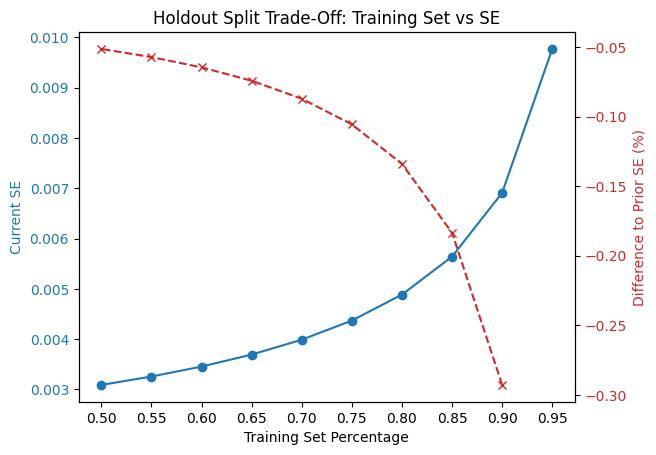

,train_size (%),train_size_count,validation_size (%),validation_size_count,test_size (%),test_size_coount,currentSE,differenceToPriorSE,differenceToPriorSE (%)
0,0.95,50767.0,0.025,1336.0,0.025,1336.0,0.009769,0.009769,inf
1,0.90,48095.0,0.050,2672.0,0.050,2672.0,0.006908,-0.002861,-0.292893
2,0.85,45423.0,0.075,4008.0,0.075,4008.0,0.005640,-0.001268,-0.183503
3,0.80,42751.0,0.100,5344.0,0.100,5344.0,0.004885,-0.000756,-0.133975
4,0.75,40079.0,0.125,6680.0,0.125,6680.0,0.004369,-0.000516,-0.105573
5,0.70,37407.0,0.150,8016.0,0.150,8016.0,0.003988,-0.000381,-0.087129
6,0.65,34735.0,0.175,9352.0,0.175,9352.0,0.003692,-0.000296,-0.074180
7,0.60,32063.0,0.200,10688.0,0.200,10688.0,0.003454,-0.000238,-0.064586
8,0.55,29391.0,0.225,12024.0,0.225,12024.0,0.003256,-0.000198,-0.057191
9,0.50,26720.0,0.250,13360.0,0.250,13360.0,0.003089,-0.000167,-0.051317


In [39]:
default_pipeline.dataset.split.asses_split_classifier(p=.85, step=.05, plot=True)

[We can see a diminishing-returns class graph](https://en.wikipedia.org/wiki/Knee_of_a_curve). The more we decline the training set percentage the slower and more steadier the current SE varies as well as the difference to prior SE, in percentage. We can see that the knee in the curve is between 80 and 90 training set percentage. This represents the area where when you start going below the lower bound, no **significant** improve appears. Given the fact that our criteria for choice of split percentage is to keep as much training possible while increasing hold-out sets size only if the decrease in SE is significant **we are going to select 80% for the training set**.

In [40]:
default_pipeline.dataset.split.split_data(y_column="Category",
                                   train_size=.8, 
                                   validation_size=.1,
                                   test_size=.1, 
                                   plot_distribution=False)

In [41]:
default_pipeline.dataset.X_train.shape, default_pipeline.dataset.X_val.shape, default_pipeline.dataset.X_test.shape, default_pipeline.dataset.y_train.shape, default_pipeline.dataset.y_val.shape, default_pipeline.dataset.y_test.shape

((42751, 142), (5344, 142), (5344, 142), (42751,), (5344,), (5344,))

<hr>

# 3. DATA PREPROCESSING

### Feature Scaling

We will work only with the training set to avoid data leakage.

In [42]:
#dataset.X_train

We eliminate the field `Reboot_before` since it is boolean.

In [43]:
# preprocessor.remove_reboot_column()
# preprocessor.X_train_without_reboot

In [44]:
# preprocessor.X_train_without_reboot.describe().T[['min', 'max']]

Secondly, we're gonna check for kurtosis and skewness. If skewness is high we might need to consider standardizing.

In [45]:
# print(f"\nSkewness:\n----------------\n{preprocessor.X_train_without_reboot.skew()}")
# print(f"\nKurtosis:\n----------------\n{preprocessor.X_train_without_reboot.kurt()}")

Since there is a very large number of fields, we need to avoid looking at the distribution and information about each feature. For this, we decided to create an automation that decides the appropriate scaling method -if necessary- for each feature.

This function `determine_scaling_method` takes into account outlier detection and skewness and based on that it decides to use a **robust scaler**, **normalize** or **none**.

**Note**: we use robust scaler rather than a standard scaler because robust scales with the median and IQR, which is less sensitive to outliers than standardizing is -computed with $\mu$ and $\sigma$. It will turn the median to 0 and turn the values in a field in values between -1 and 1 with some outliers.

Normalization Formula:
 

Robust Scaler Formula:
 
Where:

IQR (Interquartile Range) = Q3 - Q1

In [46]:
# preprocessor.prepare_scaling()

In [47]:
# X_train_scaled = preprocessor.apply_scaling()

# "\nRobust complete! The training data is now ready for modeling."

In [48]:
# X_train_scaled

The histograms show how `RobustScaler` compresses extreme values and brings the bulk of the data closer to a common scale. Despite the presence of outliers, the core distribution becomes more uniform and comparable across features — ideal for many ML models.

This section below shall be properly written. It is set now for early debugging

## !> Pipeline example
Let us show an example of the pipeline divergence. We will create a divergence for the baseline pipeline. We will exempt it from being scaled. This specific example is not meant to be kept, but rather show the purpose of the corresponding functions.

In [49]:
baseline_pipeline = pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="logistic")

In [50]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000
mean,70944.886272,12764.341700,10844.857898,47646.187738,88029.087694,14333.172277,0.0,22278.685996,17539.452434,4738.241304,...,466.232720,3.396201,0.723235,2337.759865,2.370012e+03,2296.848963,2300.166686,2300.399780,1.160519e+04,190.169821
std,36266.506343,12900.070827,999.033790,29793.858149,15871.265926,13468.721351,0.0,12570.621975,10519.885159,2939.327428,...,3644.649287,1.518657,0.981457,2203.232434,1.038044e+04,2273.580562,2031.749201,1976.428885,1.101732e+04,2.896415
min,4808.000000,0.000000,7036.000000,12.000000,4268.000000,0.000000,0.0,5113.000000,3249.000000,1012.000000,...,0.000000,0.000000,0.000000,6.000000,4.000000e+01,36.000000,45.000000,33.000000,3.121000e+03,172.000000
25%,46185.000000,3972.000000,10540.000000,31992.000000,76716.000000,4984.000000,0.0,13486.500000,10670.000000,2994.000000,...,0.000000,2.000000,0.000000,1159.000000,1.098000e+03,1107.000000,1100.000000,1135.000000,9.422000e+03,188.000000
50%,61243.000000,6356.000000,10732.000000,41444.000000,89584.000000,8180.000000,0.0,20447.000000,16560.000000,4070.000000,...,21.000000,3.000000,0.000000,2043.000000,2.020000e+03,2000.000000,2015.000000,2004.000000,1.097700e+04,190.000000
75%,91785.000000,20048.000000,11144.000000,55338.000000,99092.000000,21740.000000,0.0,28743.500000,22846.500000,5838.000000,...,124.500000,4.000000,1.000000,3054.000000,3.028000e+03,3027.000000,3026.000000,3037.000000,1.299250e+04,192.000000
max,819456.000000,106360.000000,40416.000000,809032.000000,183600.000000,110336.000000,0.0,310155.000000,286959.000000,88630.000000,...,85873.000000,12.000000,10.000000,219143.000000,2.066046e+06,142010.000000,89456.000000,102860.000000,2.067038e+06,221.000000


In [51]:
default_pipeline.preprocessing.scale_features(scaler="robust",
                                      columnsToScale=default_pipeline.dataset.X_train.select_dtypes(include=["number"]).columns)

In [52]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000
mean,0.212761,0.398628,0.186851,0.265664,-0.069490,0.367222,0.0,0.120055,0.080438,0.234965,...,3.576166,0.198101,0.723235,0.155546,0.181353,0.154609,0.148062,0.155836,0.175938,0.042455
std,0.795318,0.802443,1.654029,1.276187,0.709299,0.803815,0.0,0.823925,0.863950,1.033519,...,29.274291,0.759329,0.981457,1.162656,5.378467,1.184157,1.054906,1.039132,3.085652,0.724104
min,-1.237610,-0.395372,-6.119205,-1.774694,-3.812835,-0.488183,0.0,-1.005047,-1.093171,-1.075246,...,-0.168675,-1.500000,0.000000,-1.074934,-1.025907,-1.022917,-1.022845,-1.036278,-2.200252,-4.500000
25%,-0.330219,-0.148296,-0.317881,-0.404866,-0.575080,-0.190738,0.0,-0.456217,-0.483719,-0.378340,...,-0.168675,-0.500000,0.000000,-0.466491,-0.477720,-0.465104,-0.475078,-0.456887,-0.435513,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.669781,0.851704,0.682119,0.595134,0.424920,0.809262,0.0,0.543783,0.516281,0.621660,...,0.831325,0.500000,1.000000,0.533509,0.522280,0.534896,0.524922,0.543113,0.564487,0.500000
max,16.627478,6.220702,49.145695,32.878780,4.201645,6.096682,0.0,18.988530,22.206628,29.732771,...,689.574297,4.500000,10.000000,114.564644,1069.443523,72.921875,45.400312,53.026288,575.846800,7.750000


In [53]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000
mean,0.212761,0.398628,0.186851,0.265664,-0.069490,0.367222,0.0,0.120055,0.080438,0.234965,...,3.576166,0.198101,0.723235,0.155546,0.181353,0.154609,0.148062,0.155836,0.175938,0.042455
std,0.795318,0.802443,1.654029,1.276187,0.709299,0.803815,0.0,0.823925,0.863950,1.033519,...,29.274291,0.759329,0.981457,1.162656,5.378467,1.184157,1.054906,1.039132,3.085652,0.724104
min,-1.237610,-0.395372,-6.119205,-1.774694,-3.812835,-0.488183,0.0,-1.005047,-1.093171,-1.075246,...,-0.168675,-1.500000,0.000000,-1.074934,-1.025907,-1.022917,-1.022845,-1.036278,-2.200252,-4.500000
25%,-0.330219,-0.148296,-0.317881,-0.404866,-0.575080,-0.190738,0.0,-0.456217,-0.483719,-0.378340,...,-0.168675,-0.500000,0.000000,-0.466491,-0.477720,-0.465104,-0.475078,-0.456887,-0.435513,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.669781,0.851704,0.682119,0.595134,0.424920,0.809262,0.0,0.543783,0.516281,0.621660,...,0.831325,0.500000,1.000000,0.533509,0.522280,0.534896,0.524922,0.543113,0.564487,0.500000
max,16.627478,6.220702,49.145695,32.878780,4.201645,6.096682,0.0,18.988530,22.206628,29.732771,...,689.574297,4.500000,10.000000,114.564644,1069.443523,72.921875,45.400312,53.026288,575.846800,7.750000


In [54]:
# This is not updated (as expected)
baseline_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000
mean,70944.886272,12764.341700,10844.857898,47646.187738,88029.087694,14333.172277,0.0,22278.685996,17539.452434,4738.241304,...,466.232720,3.396201,0.723235,2337.759865,2.370012e+03,2296.848963,2300.166686,2300.399780,1.160519e+04,190.169821
std,36266.506343,12900.070827,999.033790,29793.858149,15871.265926,13468.721351,0.0,12570.621975,10519.885159,2939.327428,...,3644.649287,1.518657,0.981457,2203.232434,1.038044e+04,2273.580562,2031.749201,1976.428885,1.101732e+04,2.896415
min,4808.000000,0.000000,7036.000000,12.000000,4268.000000,0.000000,0.0,5113.000000,3249.000000,1012.000000,...,0.000000,0.000000,0.000000,6.000000,4.000000e+01,36.000000,45.000000,33.000000,3.121000e+03,172.000000
25%,46185.000000,3972.000000,10540.000000,31992.000000,76716.000000,4984.000000,0.0,13486.500000,10670.000000,2994.000000,...,0.000000,2.000000,0.000000,1159.000000,1.098000e+03,1107.000000,1100.000000,1135.000000,9.422000e+03,188.000000
50%,61243.000000,6356.000000,10732.000000,41444.000000,89584.000000,8180.000000,0.0,20447.000000,16560.000000,4070.000000,...,21.000000,3.000000,0.000000,2043.000000,2.020000e+03,2000.000000,2015.000000,2004.000000,1.097700e+04,190.000000
75%,91785.000000,20048.000000,11144.000000,55338.000000,99092.000000,21740.000000,0.0,28743.500000,22846.500000,5838.000000,...,124.500000,4.000000,1.000000,3054.000000,3.028000e+03,3027.000000,3026.000000,3037.000000,1.299250e+04,192.000000
max,819456.000000,106360.000000,40416.000000,809032.000000,183600.000000,110336.000000,0.0,310155.000000,286959.000000,88630.000000,...,85873.000000,12.000000,10.000000,219143.000000,2.066046e+06,142010.000000,89456.000000,102860.000000,2.067038e+06,221.000000


### Outliers 

In [55]:
#models_pipeline.preprocessing.get_outliers_df(plot=True)

<hr>

# 4. FEATURE ANALYSIS

Here we will take adjust the features that compose the learning inputs to our model. The correctness of this section is pivotal for proper learning by the model


## FEATURE ENGINEERING
- Domain-specific features
- Binning
- Interaction terms


In [56]:
featuresToEncode = ["Reboot"]

In [57]:
encoded_maps_perPipeline = pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_transformation.get_categorical_features_encoded", verbose=True, features=featuresToEncode, encode_y=True)

Pipeline logistic in category baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}
Pipeline ensembled in category models has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}


Lets visualize the results of the encoding...

In [58]:
default_pipeline.dataset.X_train

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Reboot_before
48143,-0.572982,-0.212739,3.662252,-0.680374,-0.269575,-0.304846,0.0,-0.744642,-0.903544,-0.190928,...,0.0,0.0,1.229024,0.414508,-0.328646,-0.232606,1.436909,1.088923,-0.50,1
10388,0.223136,0.310774,-2.933775,0.225135,-0.211834,0.196228,0.0,-0.345350,-0.408902,-0.166667,...,-0.5,2.0,-0.712401,-0.995337,0.449479,-0.162513,0.420610,-0.788685,0.25,0
11029,1.298399,1.525006,-0.046358,1.288786,1.902038,1.401289,0.0,1.092089,1.166345,0.800281,...,-0.5,1.0,0.200000,0.486528,-0.559896,-0.995327,0.742376,-0.324044,1.50,0
36609,-0.407325,-0.136850,3.000000,-0.495674,0.071505,-0.239198,0.0,-0.469555,-0.483883,-0.511955,...,1.0,2.0,0.147757,-0.969430,-0.633854,-0.031672,0.475289,-0.801008,0.50,0
26413,0.097281,-0.192834,0.099338,0.481453,0.522524,-0.129864,0.0,0.760766,0.679752,1.106188,...,0.0,0.0,0.120317,2.872539,-0.715625,-0.098131,-0.980547,0.405826,0.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42697,-0.562982,-0.382433,0.543046,-0.389446,-1.457991,-0.475531,0.0,-0.748509,-0.895085,-0.247890,...,0.0,1.0,-0.127704,-0.263212,-0.177083,-0.367082,-0.841220,-1.202073,-0.25,1
36008,-0.192939,-0.072157,2.847682,-0.232845,0.407222,-0.058009,0.0,-0.160779,-0.123270,-0.399437,...,0.0,0.0,-1.018470,0.315026,-0.623958,0.314642,2.321241,0.449797,0.75,0
46265,-0.526820,-0.179895,3.112583,-0.588366,-0.299428,-0.280019,0.0,-0.681523,-0.782819,-0.369198,...,1.0,1.0,0.812137,1.255440,-0.403646,-0.323988,0.519453,0.743873,-0.25,1
23587,1.155789,2.092560,0.198675,0.827551,0.464247,1.995942,0.0,1.539293,1.188190,3.105837,...,1.0,0.0,-0.589446,0.521762,-0.255208,-0.055556,1.700315,0.457079,-0.75,1


In [59]:
default_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

In [60]:
baseline_pipeline.dataset.X_train

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Reboot_before
48143,35115,2936,12944,25560,83552,3072,0,9086,5558,3527,...,3,0,4372,2820,1369,1567,4737,14865,188,1
10388,71418,11352,8960,46700,84844,11468,0,15178,11581,3596,...,2,2,693,99,2863,1702,2804,8161,191,0
11029,120450,30872,10704,71532,132144,31660,0,37109,30762,6346,...,2,1,2422,2959,925,98,3416,9820,196,0
36609,42669,4156,12544,29872,91184,4172,0,13283,10668,2614,...,5,2,2323,149,783,1954,2908,8117,192,0
26413,65679,3256,10792,52684,101276,6004,0,32054,24837,7216,...,3,0,2271,7564,626,1826,139,12426,192,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42697,35571,208,11060,32352,56960,212,0,9027,5661,3365,...,3,1,1801,1512,1660,1308,404,6685,189,1
36008,52445,5196,12452,36008,98696,7208,0,17994,15059,2934,...,3,0,113,2628,802,2621,6419,12583,193,0
46265,37220,3464,12612,27708,82884,3488,0,10049,7028,3020,...,5,1,3582,4443,1225,1391,2992,13633,189,1
23587,113947,39996,10852,60764,99972,41624,0,43932,31028,12903,...,5,0,926,3027,1510,1908,5238,12609,187,1


In [61]:
baseline_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

## FEATURE SELECTION
- Analyze correlation and low-variances


## Feature selection 
As explained before, we now proceed to carefully reduce the present high-dimensionality. High-dimensionality increases the chances of the model overfitting (capturing noise from irrelevant features; increasing variance and reducing bias), as well as introducing a significant computational overhead. We match this high-dimensionality with a highly filtering models_pipeline of feature selection.
The most extensive cut comes given at the first level, with the mutual information threshold-based cut. This metric captures the level of uncertainity between the feature and the target variable (cnt). In marked contrast with pearson coefficeint (correlation), it is able to model non-linear and linea relationships altoghther. 
This feature-selectin models_pipeline is compromised of five (3 as of the final models_pipeline) cuts:
 - mutual information
 - low variance
 - multicolinearity analysis
 - PCA
 - Boruta and/or Lasso

The different thresholds for each of this cuts have been altered over the different models_pipeline iterations. Specifically, in the bias-variance tradeoff (to be elaborated in further detail later), I increased all the thresholds in order to avoid por performance.

#### Feature to target variable mutual information

In [62]:
# models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="MutualInformation", threshold=.2, delete_features=True, plot=True)

#### Eliminating low-variances features
Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset. The reason why we don't focus on high-variance is because this symbolizes outliers, which have been dealt with before in data preporcesing.
This function call eliminate low-variance (based on threshold) and all cosntant variables (regardless of threshold)

We will start off this analysis eliminating univariate features (i.e: the featuers with constant values)

In [63]:
# default_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="LowVariances", 
#                                                                          threshold=0.5, 
#                                                                          delete_features=True, 
#                                                                          plot=True)

As explained in scikit-learn's in (1.13.1 Feature selection)[https://scikit-learn.org/stable/modules/feature_selection.html], the variance threshold must be selected carefully. Too low may delete few variables, and too may be too restrictive, deleting more variables than it should.

#### Eliminating highly correlated feature 
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.
Well, thats a lot to digest! We can see some solid red (high positive correlation) and medium-solid blue (some high negative correlation). 
Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.
A brief explanation on VIF. 
Formula: 
$$
VIF_i = \frac{1}{1 - R_i^2}
$$
You regress (i.e: do linear regression) on the ith feature as target variable, and all other features as predictors. You then compute the coefficient of determination as a way to measure how well the predictors fit the target variable. VIF values ranges from [1, inf], where lower bound signifies little multicolinearity (R^2 = 0), and upper bound occurs when R^2=1 (perfect multicolineairty). 5 is considered a standard threshold for VIF as it symbolized an 80% R^2.
Once you ve obtained the results of VIF, you need to delete the variable with the highest VIF, and recompute VIF until there is no multicolinearity. For example, say there are three features that are 4 features, 3 of them being linear combinations of each other. You would delete the variables with VIF until there is no VIF (when only one of those linear combinations remains). You cant delete all n-1 variables where n are the amount of variables with exceeding (with respect to the chosen threshold), because you may be deleting one that has high VIF due to another feature.

A relevant note on why one-hot-encoding must be done dropping the first one:
If we were to not remove one of the labels of one hot encoding, you would be able to predict which level of the categorical variable based on all other ones (there is only degree of freedom for categories levels; they are a linear combination). You would essentially see inf VIF in that area and delete it in this section. 
The VIF has to be computed every time we delete a feature due to high multicolinearity. Lets do that

In [64]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="VIF", threshold=10, delete_features=True, plot=False)

### PCA
PCA can still bring some more value to feature selection. It will take into account interaction effects by itself and find the principals that capture as much variance as we specify. Thus, its inclusion in the feature selection models_pipeline.
It has been excldued due to underperformance.

In [65]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="PCA", threshold=.95, delete_features=False, plot=False)

### 1.3 Automatic Feature Selection
#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses. The reason why it sets 0 to insignificant feature is because the objective function is not only the MSE but added a component of the wieght magnitude (which is trying to minimize)

In [66]:
# excluded_features, predictive_features, coefficients = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="L1",
#                                                                                                                                     max_iter=1000, 
#                                                                                                                                     print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

#### BORUTA
Boruta is a more powerful feature selection method (thus we use it as a reference for variable deletion). It is more powerful that L1 becuase it compares the importance of features to shuffled versions, ensuring robust feature selection


In [67]:
# excluded_features, predictive_features = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="Boruta", max_iter=10, print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

Awesome, lets move onto the actual modelling part!

<hr>

# MODELLING

## Fitting the model

QUESTIONS FOR THIS SECTION
- Can the ROC curve be used for multiclass?
- Can a unsupervised learning algorithm (e.g: KNN) be used for this problem even tough its nature is to be supervised?
- Does val to train deltas are meaningful here?

TO BE DONE FOR THIS SECTION
- Multiple models as classifiers
- Learn more about each alogrithms' paremters
- Can KNN be used here?

## Random Forest & Decision Trees
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster. We will add its not ensembled version too, along with gradient boosted machine
Note we are not using not-by-default multiclass classifiers (e.g: logistic regressions, svms)

## Non-optimized fitting
We first fit all these models with the default paramterers. This is done to constrat more starkly the difference between pre and post tuning.

In [68]:
# Ensembled models
gradientBoostingModel = GradientBoostingClassifier()
randomForestModel = RandomForestClassifier()

# Tree-based models
decisionTreeModel = DecisionTreeClassifier()

# Linear models
supportVectorModel = SVC()

# Baseline
logisticRegressionModel = LogisticRegression()

#### MODEL PERFORMANCE, HYPOTHESIS
- Trees (e.g: random forest, decision trees):
  - Time to fit:
    - Ensemble models (random forest) take more time to train due to the fact that they are larger and heavier than their non-ensembled version. 
  - Correctness:
     - High
- Binary-classifiers by default models (e.g: SMV, logistic regression)
  - Time to fit:
    - compute C models for all C number of classes. Each trained to detect a single class, then when we make predictions, we select the ones that has the highest probability in its predictions ("the most confident in its prediction"). This strategy is called One-vs-Rest, note however, a single logistic regression may be used if we used the softmax objective function (instead of log-odds) (it still heavy computationally, tough). They will be sloder than ensemble models
  - Correctness:
     - Very low if the problem is non-linear which it is for the SVM and logistic regression

In [69]:
pipeline_manager.pipelines

{'models': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x155f27d10>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x155f27d10>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x155f27d10>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x157b79a50>}}

Pipelines always need to diverge from training onwards. Otherwise they will have each other results (which does not follow the isolation pattern we have programmed this with)

In [70]:
ensembled_pipeline = pipeline_manager.create_pipeline_divergence(category="models", pipelineName="ensembled")
linear_pipeline = pipeline_manager.create_pipeline_divergence(category="models", pipelineName="linear")

In [71]:
pipeline_manager.pipelines

{'models': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x157c09d50>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x155f27d10>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x157bfee50>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x157b79a50>}}

In [72]:
# Ensembled models
ensembled_pipeline.model_selection.add_model("Gradient Boosting", gradientBoostingModel)
ensembled_pipeline.model_selection.add_model("Random Forest", randomForestModel)

# Tree-based models
tree_pipeline.model_selection.add_model("Decision Tree", decisionTreeModel)

# Linear models
linear_pipeline.model_selection.add_model("SVM", supportVectorModel) 

# Baseline
baseline_pipeline.model_selection.add_model("Logistic Regression", logisticRegressionModel)


While we debug, lets exlclude some models we dont need for now (they are very slow to train)

In [73]:
# Ensembled models
ensembled_pipeline.model_selection.models_to_exclude = ["Gradient Boosting"]

# Tree-based models
tree_pipeline.model_selection.models_to_exclude = []

# Linear models
linear_pipeline.model_selection.models_to_exclude = ["SVM"]

# Baseline
baseline_pipeline.model_selection.models_to_exclude = ["Logistic Regression"]


In [74]:
pipeline_manager.all_pipelines_execute(methodName="model_selection.fit_models", current_phase="pre")

All models have been fitted and made predictions in parallel.
All models have been fitted and made predictions in parallel.
=> Fitting Decision Tree model
Sklearn model: DecisionTreeClassifier()
!> Started fitting Decision Tree
Lenght of X_data: 42751
=> Fitting Random Forest model
Sklearn model: RandomForestClassifier()
!> Started fitting Random Forest
Lenght of X_data: 42751
		 => Fitted Decision Tree. Took 1.921435832977295 seconds
=> Predicting Decision Tree model
!> Started predicting Decision Tree
		 => Predicted Decision Tree. Took 0.003476858139038086 seconds
All models have been fitted and made predictions in parallel.
		 => Fitted Random Forest. Took 9.882768869400024 seconds
=> Predicting Random Forest model
!> Started predicting Random Forest
		 => Predicted Random Forest. Took 0.08477902412414551 seconds
All models have been fitted and made predictions in parallel.


{'models': {'linear': None, 'tree-based': None, 'ensembled': None},
 'baseline': {'logistic': None}}

Let's make sure the predictions vary between holdout sets

<i> the aforeshown diagram was originally done with the sole intention to debug an error that made predictions be the same across sets. Insights may not be much meaningful after correctio, but it is worth keeping until the end of the notebook development </i>

### PREDICTIONS RESULTS 
Before we get into the actual results, lets elaborate briefly on all the metrics that we are using to asses our classifiers:

- Accuracy => total correctly predicted elemetnts (sigma over the moments we predicted x_i and it was actually x_i / number_of_samples)
$$
\text{Accuracy} = \frac{\sum_{i} \mathbf{1}(\hat{y}_i = y_i)}{N}
$$
- Precision => out of how many predicted for that class were actually from that class (predicted for class x when it was x/ predicted for class x when it was x + predicted for class x when it was NOT x)
$$
\text{Precision}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FP}_x}
$$
- Recall => out of all cases that were positive how many got predicted correctly?
$$
\text{Recall}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FN}_x}
$$
- F1-score => harmonic mean of precision and recall (balances both metrics, heavily penalize spreadness between ratios that are being averaged out)
$$
\text{F1}_x = 2 \times \frac{\text{Precision}_x \times \text{Recall}_x}{\text{Precision}_x + \text{Recall}_x}
$$
- Support => number of actual occurences of class in the dataset
- macro avg => averages given metric across all classes
$$
\text{Macro Avg} = \frac{1}{C} \sum_{i=1}^{C} M_i
$$
- weighted avg => averages with weights per class occurence (considers frequency of class in average computation)
$$
\text{Weighted Avg} = \sum_{i=1}^{C} \frac{\text{Support}_i}{\text{Total Instances}} \times M_i
$$

In [75]:
comments = "wiLL THIS work?"

In [76]:
model_results = pipeline_manager.all_pipelines_execute(methodName="model_selection.evaluate_models", comments=comments, current_phase="pre")

All models have been evaluated.All models have been evaluated.
[DEBUG] Starting store_results

[DEBUG] Starting store_results
[DEBUG 0.01s] Completed store_results, processed 0 models
[DEBUG 0.10s] Completed store_results, processed 0 models
METRIC RESULTS FOR Decision Tree => F1: 0.7569155448174679, Precision: 0.7558176403082072, Recall: 0.7587949101796407, Accuracy: 0.7587949101796407
METRIC RESULTS FOR Random Forest => F1: 0.8380239140339026, Precision: 0.8458369157632336, Recall: 0.843375748502994, Accuracy: 0.843375748502994
All models have been evaluated.
[DEBUG] Starting store_results
Metadata is: {'id': None, 'timeStamp': None, 'comments': None, 'modelName': 'Decision Tree', 'currentPhase': None, 'features_used': None, 'hyperParameters': None, 'timeToFit': 1.921435832977295, 'timeToPredict': 0.003476858139038086, 'classification_report': {'0': {'precision': 0.7810945273631841, 'recall': 0.7881526104417671, 'f1-score': 0.784607696151924, 'support': 996.0}, '1': {'precision': 0.6

## Performance Evaluation (pre-tuning)
Below are shown all the metrics we can compare our plots to:

In [82]:
pipeline_manager.pipelines_analysis._compute_classification_report(phase="pre").T

,precision,recall,f1-score,support,precision,recall,f1-score,support
0,0.769293,0.950803,0.850471,996.0,0.781095,0.788153,0.784608,996.0
1,0.880952,0.660714,0.755102,112.0,0.650485,0.598214,0.623256,112.0
2,0.933333,0.56,0.7,25.0,0.75,0.6,0.666667,25.0
3,0.831858,0.454106,0.5875,207.0,0.444444,0.36715,0.402116,207.0
4,0.911765,0.762295,0.830357,122.0,0.692913,0.721311,0.706827,122.0
5,0.798982,0.884507,0.839572,355.0,0.780347,0.760563,0.770328,355.0
6,0.896194,0.914548,0.905278,1416.0,0.83322,0.864407,0.848527,1416.0
7,0.855072,0.786667,0.819444,75.0,0.703704,0.76,0.730769,75.0
8,0.870793,0.903153,0.886678,888.0,0.815456,0.796171,0.805698,888.0
9,0.818182,0.666667,0.734694,27.0,0.571429,0.592593,0.581818,27.0


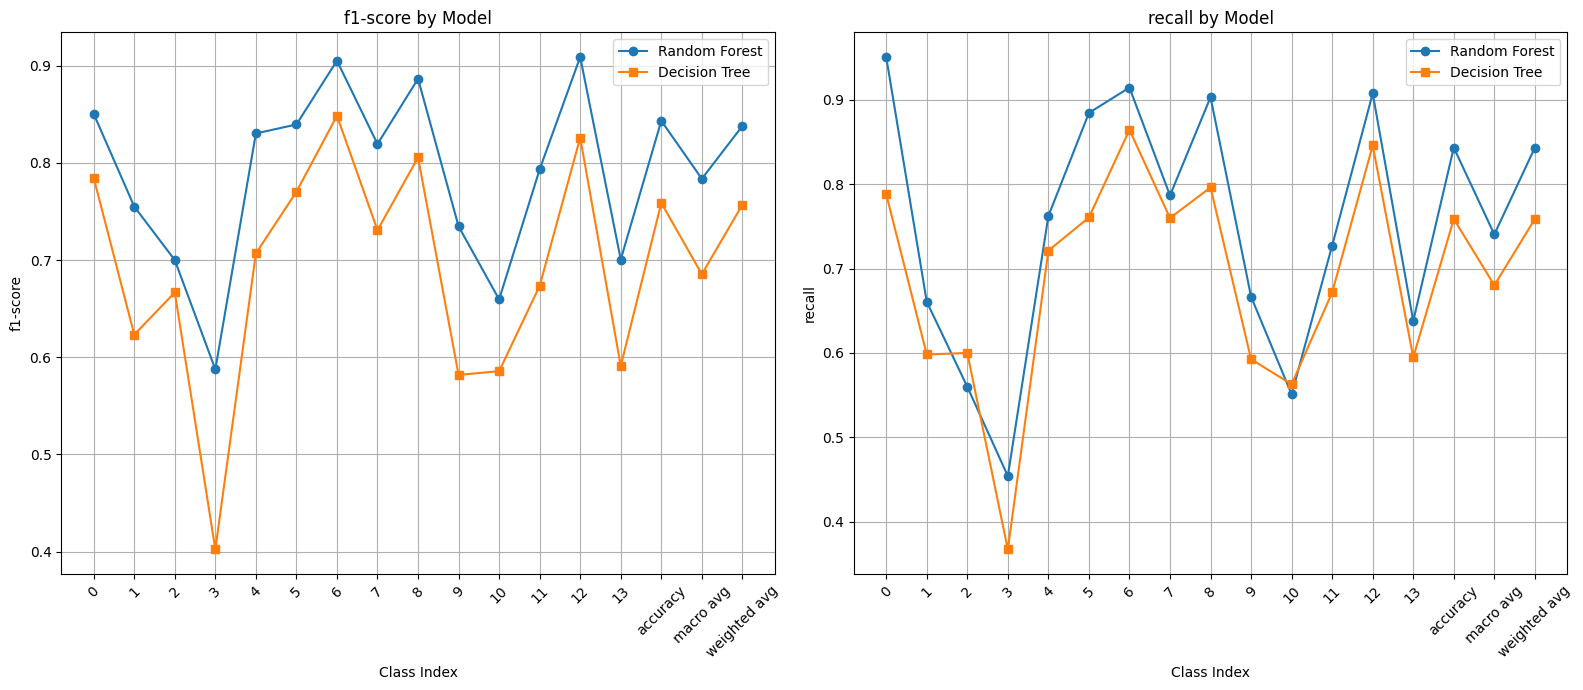

In [79]:
pipeline_manager.pipelines_analysis.plot_classification_report(metric=["f1-score", "recall"] ,phase="pre")


In [83]:
pipeline_manager.pipelines["models"]["ensembled"].dataset.df["Category"].value_counts()

Category
Riskware          14053
Adware            10980
Trojan             8437
Zero_Day           4475
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
No_Category        1932
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

In [80]:
model_results["models"]["ensembled"].columns

Index(['id', 'timeStamp', 'comments', 'modelName', 'currentPhase',
       'features_used', 'hyperParameters', 'timeToFit', 'timeToPredict',
       'classification_report', 'accuracy_val', 'accuracy_test',
       'precision_val', 'precision_test', 'recall_val', 'recall_test',
       'f1-score_val', 'f1-score_test'],
      dtype='object')

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


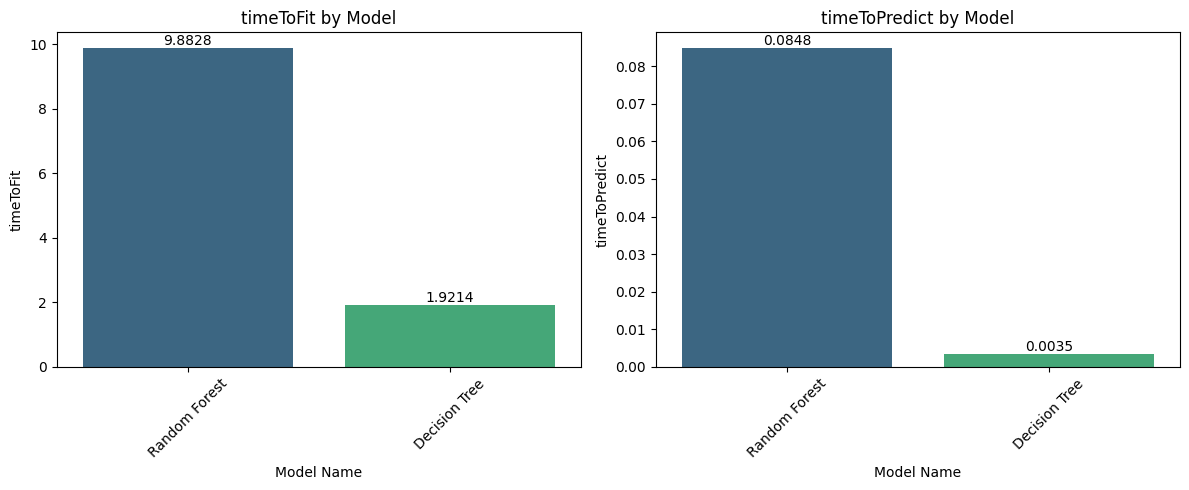

In [81]:
pipeline_manager.pipelines_analysis.plot_results_df(
                                                         metrics=["timeToFit", "timeToPredict"], 
                                                         phase="pre")

## Residual analysis (pre-tuning)
Gotta add the mappers naming to the plot


This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

### Confusion Matrix

In [ ]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix(phase="pre")
residuals

PLOTS:
- Early signs of overfitting


## Feature importances (pre-tuning)

In [ ]:
importances_dfs = pipeline_manager.pipelines_analysis.pot_feature_importance(phase="pre")
importances_dfs

# Hyperparameter Optimization